In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Rsi6')

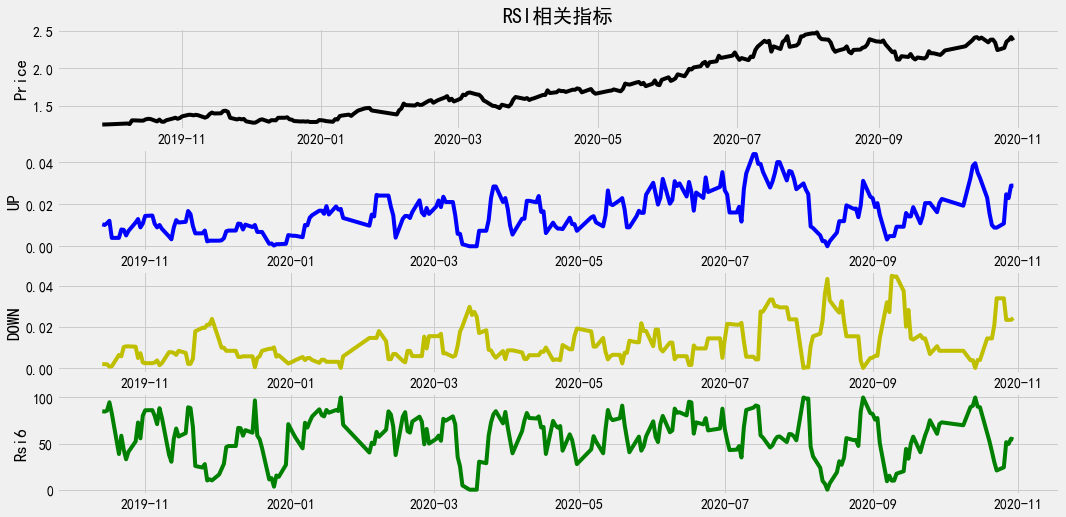

In [52]:
BOCM=pd.read_excel('C:\\Users\\10690\\Desktop\\量化基金\\中信混合.xlsx')
BOCM.index=BOCM.iloc[:,0]
BOCM.index=pd.to_datetime(BOCM.index,format='%y-%m-%d')
BOCMclp=BOCM.price
clprcChange=BOCMclp-BOCMclp.shift(1)
clprcChange=clprcChange.dropna()
indexprc=clprcChange.index
upPrc=pd.Series(0,index=indexprc)
upPrc[clprcChange>0]=clprcChange[clprcChange>0]
downPrc=pd.Series(0,index=indexprc)
downPrc[clprcChange<0]=-clprcChange[clprcChange<0]
rsidata=pd.concat([BOCMclp,clprcChange,upPrc,downPrc],axis=1)
rsidata.columns=['Close','PrcChange','upPrc','downPrc']
rsidata=rsidata.dropna();

SMUP=[]
SMDOWN=[]

for i in range(6,len(upPrc)+1):
    SMUP.append(np.mean(upPrc.values[(i-6):i],dtype=np.float32))
    SMDOWN.append(np.mean(downPrc.values[(i-6):i],dtype=np.float32))
    
rsi6=[100*SMUP[i]/(SMUP[i]+SMDOWN[i]) for i in range(0,len(SMUP))]

indexRsi=indexprc[5:]
Rsi6=pd.Series(rsi6,index=indexRsi)
Rsi6.head()
Rsi6.describe()

fig=plt.figure(figsize=(16,8))
UP=pd.Series(SMUP,index=indexRsi)
DOWN=pd.Series(SMDOWN,index=indexRsi)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(411)
plt.plot(BOCMclp,'k')
plt.xlabel('date')
plt.ylabel('Price')
plt.title('RSI相关指标')
plt.subplot(412)
plt.plot(UP,'b')
plt.ylabel('UP')
plt.subplot(413)
plt.plot(DOWN,'y')
plt.ylabel('DOWN')
plt.subplot(414)
plt.plot(Rsi6,'g')
plt.ylabel('Rsi6')

# 玩法一：80/20玩法

In [53]:
def rsi(price,period=6):
    import pandas as pd
    clprcChange=price-price.shift(1)
    clprcChange=clprcChange.dropna()
    indexprc=clprcChange.index
    upPrc=pd.Series(0,index=indexprc)
    upPrc[clprcChange>0]=clprcChange[clprcChange>0]
    downPrc=pd.Series(0,index=indexprc)
    downPrc[clprcChange<0]=-clprcChange[clprcChange<0]
    rsidata=pd.concat([price,clprcChange,upPrc,downPrc],axis=1)
    rsidata.columns=['price','PrcChange','upPrc','downPrc']
    rsidata=rsidata.dropna();
    SMUP=[]
    SMDOWN=[]
    for i in range(period,len(upPrc)+1):
        SMUP.append(np.mean(upPrc.values[(i-period):i],dtype=np.float32))
        SMDOWN.append(np.mean(downPrc.values[(i-period):i],dtype=np.float32))
        rsi=[100*SMUP[i]/(SMUP[i]+SMDOWN[i]) for i in range(0,len(SMUP))]
    indexRsi=indexprc[(period-1):]
    rsi=pd.Series(rsi,index=indexRsi)
    return(rsi)

### 时间节点分别是6和24天

In [54]:
Rsi6=rsi(BOCMclp,6)
Rsi24=rsi(BOCMclp,24)

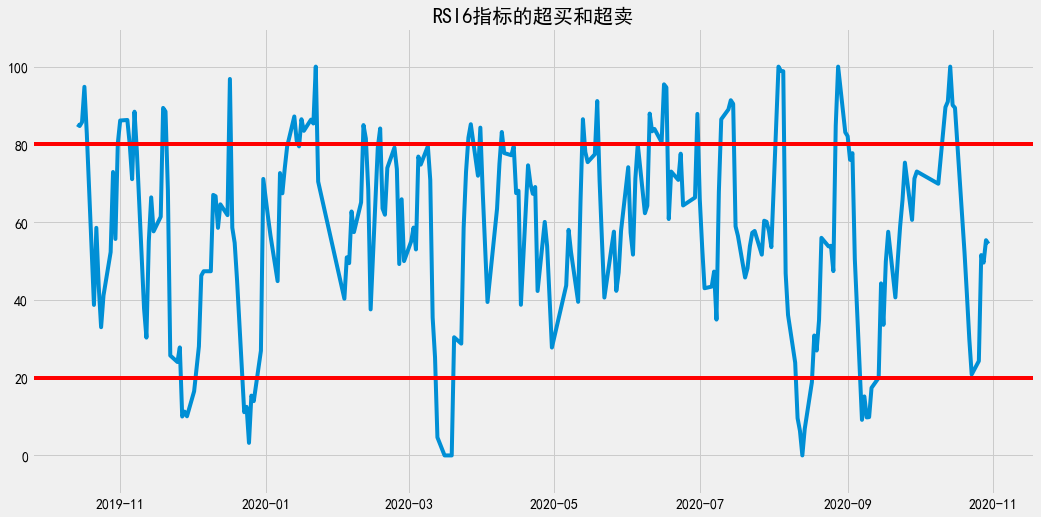

In [55]:
fig=plt.figure(figsize=(16,8))
plt.plot(Rsi6)
plt.title('RSI6指标的超买和超卖')
plt.ylim(-10,110)

plt.axhline(y=80,color='red')
plt.axhline(y=20,color='red')
plt.show()

# 玩法二：交叉线

### 时间节点分别是10和40天

In [56]:
rsi6=rsi(BOCMclp,10)
rsi24=rsi(BOCMclp,40)

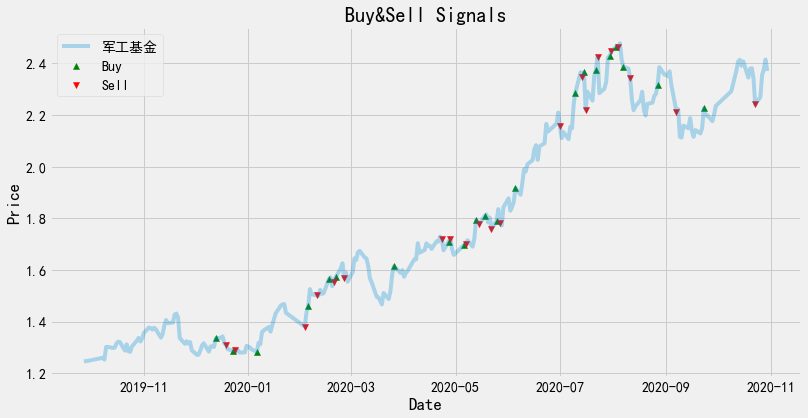

In [57]:
Sig1=[]
for i in rsi6:
    if i>80:
        Sig1.append(-1)
    elif i<20:
        Sig1.append(1)
    else:
        Sig1.append(0)
    
date1=rsi6.index
Signal1=pd.Series(Sig1,index=date1)
Signal2=pd.Series(0,index=rsi24.index)
lagrsi6=rsi6.shift(1)
lagrsi24=rsi24.shift(1)
for i in rsi24.index:
    if (rsi6[i]>rsi24[i])&(lagrsi6[i]<lagrsi24[i]):
        Signal2[i]=1
    elif (rsi6[i]<rsi24[i])&(lagrsi6[i]>lagrsi24[i]):
        Signal2[i]=-1

signal=Signal1+Signal2
signal[signal>=1]=1
signal[signal<=-1]=-1
signal=signal.dropna()
tradSig=signal.shift(1)
ret=BOCMclp/BOCMclp.shift(1)-1
ret=ret[tradSig.index]
buy=tradSig[tradSig==1]
buyRet=ret[tradSig==1]*buy
sell=tradSig[tradSig==-1]
sellRet=ret[tradSig==-1]*sell
tradeRet=ret*tradSig

def start(tradeSignal,ret):
    indexDate=tradeSignal.index
    ret=ret[indexDate]
    tradeRet=ret*tradeSignal
    tradeRet[tradeRet==(-0)]=0
    winRate=len(tradeRet[tradeRet>0])/len(tradeRet[tradeRet!=0])
    meanWin=sum(tradeRet[tradeRet>0])/len(tradeRet[tradeRet>0])
    meanLoss=sum(tradeRet[tradeRet<0])/len(tradeRet[tradeRet<0])
    perform={'WinRate':winRate,'meanWin':meanWin,'meanLoss':meanLoss}
    return(perform)

tradSig2=signal.shift(3)
ret2=ret[tradSig2.index]
buy2=tradSig[tradSig2==1]
buyRet2=ret2[tradSig2==1]*buy2
sell2=tradSig2[tradSig2==-1]
sellRet2=ret2[tradSig2==-1]*sell2
tradeRet2=ret2*tradSig2
BuyOnly2=start(buy2,ret2)
SellOnly2=start(sell2,ret2)
Trade2=start(tradSig2,ret2)
Test2=pd.DataFrame({"BuyOnly":BuyOnly2,"SellOnly":SellOnly2,"Trade":Trade2})

s2=Signal2[Signal2==1]
s1=Signal2[Signal2==-1]

plt.figure(figsize=(12,6))
plt.style.use('fivethirtyeight')
plt.plot(BOCM.price,label='军工基金',alpha=0.3)
plt.scatter(s2.index,BOCM.loc[s2.index].price,label='Buy',marker='^',color='green')
plt.scatter(s1.index,BOCM.loc[s1.index].price,label='Sell',marker='v',color='red')
plt.title('Buy&Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')

In [58]:
#Buy
s2['2020'].index

DatetimeIndex(['2020-01-06', '2020-02-05', '2020-02-17', '2020-02-21',
               '2020-03-26', '2020-04-27', '2020-05-06', '2020-05-13',
               '2020-05-18', '2020-05-25', '2020-06-05', '2020-07-10',
               '2020-07-15', '2020-07-22', '2020-07-30', '2020-08-03',
               '2020-08-07', '2020-08-27', '2020-09-23'],
              dtype='datetime64[ns]', name='date', freq=None)

In [59]:
#Sell
s1['2020'].index

DatetimeIndex(['2020-02-03', '2020-02-10', '2020-02-20', '2020-02-26',
               '2020-04-23', '2020-04-28', '2020-05-07', '2020-05-15',
               '2020-05-22', '2020-05-27', '2020-07-01', '2020-07-14',
               '2020-07-16', '2020-07-23', '2020-07-31', '2020-08-04',
               '2020-08-11', '2020-09-07', '2020-10-23'],
              dtype='datetime64[ns]', name='date', freq=None)

# 开始算账

In [60]:
temp01sell=BOCM.loc[s1.index,'price']
temp01sell=temp01sell.to_frame() #.insert(2,'buy',1)
type(temp01sell)
temp01sell.columns=['Sell']

temp01buy=BOCM.loc[s2.index,'price']
temp01buy=temp01buy.to_frame() #.insert(2,'buy',1)
type(temp01buy)
temp01buy.columns=['Buy']

newdf=pd.DataFrame()
newdf=pd.concat([temp01buy,temp01sell],sort=True)
newdf=newdf.sort_index()
newdf['diff']=newdf['Sell'].shift(-1)
newdf['pct']=(newdf['diff']-newdf['Buy'])/newdf['Buy']
newdf.dropna(subset=['pct'],inplace=True)

print("起始金额")
plus=0
minus=0
benjin=1000
start=benjin
print(start)
print('')
# for i in newdf['pct'].to_list()[:-1]:
for i in newdf['pct'].to_list():
    if i<0:
        print(1+i)
        start=start*(1+i)
        print("当前亏损，亏损%0.2f 当前本金是%0.2f"%(1+i,start))
        minus+=1
    else:
        print(1+i)
        start=start*(1+i)
        print("当前盈利，涨幅%0.2f 当前本金是%0.2f"%(1+i,start))
        plus+=1
    i=0
#     print('')
print("策略后金额")
print("%0.2f"%(start))
var2=((start-benjin)/benjin)*100
print("累计收益%0.2f%%"%(var2))
print("累计胜负 胜%d，负%d"%(plus,minus))

起始金额
1000

0.9812874251497005
当前亏损，亏损0.98 当前本金是981.29
1.0015540015540016
当前盈利，涨幅1.00 当前本金是982.81
1.0760717069368668
当前盈利，涨幅1.08 当前本金是1057.58
1.0282172453941512
当前盈利，涨幅1.03 当前本金是1087.42
0.9939242773087745
当前亏损，亏损0.99 当前本金是1080.81
0.998345424462263
当前亏损，亏损1.00 当前本金是1079.02
1.0659272569552016
当前盈利，涨幅1.07 当前本金是1150.16
1.0067302627728683
当前盈利，涨幅1.01 当前本金是1157.90
1.0019451812555262
当前盈利，涨幅1.00 当前本金是1160.15
0.9925252412562058
当前亏损，亏损0.99 当前本金是1151.48
0.9724065472240655
当前亏损，亏损0.97 当前本金是1119.71
0.9939681653169506
当前亏损，亏损0.99 当前本金是1112.95
1.1245564600292215
当前盈利，涨幅1.12 当前本金是1251.58
1.025896762904637
当前盈利，涨幅1.03 当前本金是1283.99
0.9386710654316288
当前亏损，亏损0.94 当前本金是1205.25
1.021392175853792
当前盈利，涨幅1.02 当前本金是1231.03
1.0086135839103196
当前盈利，涨幅1.01 当前本金是1241.63
0.9992694805194806
当前亏损，亏损1.00 当前本金是1240.73
0.980974730754725
当前亏损，亏损0.98 当前本金是1217.12
0.9557197166061863
当前亏损，亏损0.96 当前本金是1163.23
1.0069216594004224
当前盈利，涨幅1.01 当前本金是1171.28
策略后金额
1171.28
累计收益17.13%
累计胜负 胜11，负10


### 所以，要科学的抓住机遇，别让“回撤”让你白开心一场